# EdgePhase

In this study, we build a multi-station phase-picking model named EdgePhase by integrating an Edge Convolutional module with a state-of-the-art single-station phase-picking model, EQTransformer. The Edge Convolutional module, a variant of Graph Neural Network, exchanges information relevant to seismic phases between neighboring stations. In EdgePhase, seismograms are first encoded into the latent representations, then converted into enhanced representations (”Enhanced” in this context refers to the improved representation ability) by Edge Convolutional module, and finally decoded into the P- and S-phase probabilities.
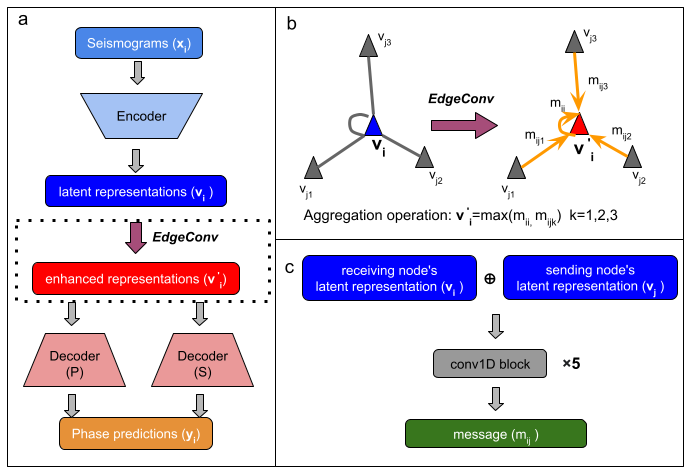
---






## Data and Package Dependency

### Install Packages
restart runtime after installing all packages.

In [ ]:
% cd /content
!git clone https://github.com/lovelytt0/EdgePhase
!pip install pytorch_lightning
# GPU
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu115.html
# CPU
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html

!pip install seisbench
!python -m pip install scipy==1.6 --upgrade
# !pip uninstall obspy
!pip install obspy


/content
Cloning into 'EdgePhase'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 122 (delta 38), reused 103 (delta 24), pack-reused 0
Receiving objects: 100% (122/122), 34.42 MiB | 29.30 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 140 kB 72.6 MB/s 
     |████████████████████████████████| 409 kB 70.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.4 MB/s 
     |████████████████████████████████| 271 kB 35.0 MB/s 
     |████████████████████████████████| 144 kB 69.7 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling Py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.4 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Data
[1] Upload data into content folder and unzip them.

In [ ]:
# !unzip Data.zip

[2] Load from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Data_Path = '/content/drive/MyDrive/Data'
!ls $Data_Path

continous_data	training_data


### Import Packages

In [ ]:
import os
import sys
import gc 
import shutil
import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm

import time
import pickle
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

from torch_geometric.nn import MessagePassing
import seisbench.models as sbm

import obspy
from obspy.geodetics.base import locations2degrees
from glob import glob
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

## Define Data Generator

Has the function to feed training, validation, or testing samples to the network.

In [ ]:
class DataGeneratorMulti(torch.utils.data.Dataset):
    
    """ 
    
    Keras generator with preprocessing 
    
    Parameters
    ----------
    list_IDsx: str
        List of trace names.
            
    file_name: str
        Name of hdf5 file containing waveforms data.
            
    dim: tuple
        Dimension of input traces. 
           
    batch_size: int, default=32
        Batch size.
           
            
    shuffle: bool, default=True
        Shuffeling the list.
            
    norm_mode: str, default=max
        The mode of normalization, 'max' or 'std'.
             
    augmentation: bool, default=True
        If True, half of each batch will be augmented version of the other half.
            
    """   
    
    def __init__(self, 
                 list_IDs, 
                 file_name='Dataset_builder', 
                 dim = 6000, 
                 batch_size=1, 
                 shuffle=True, 
                 norm_mode = 'std',
                 augmentation = False,                  
                 ):
       
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.file_name = file_name        
        self.shuffle = shuffle
        self.norm_mode = norm_mode
        self.augmentation = augmentation   
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # print(self.list_IDs[index])
        X, y, edge_index = self._data_generation(self.list_IDs[index])
        return torch.tensor(X, dtype=torch.float),torch.tensor(y, dtype=torch.float), torch.tensor(edge_index), self.list_IDs[index]
    
    def testitem(self, index):     
        'Generate one batch of test data'
        X, y, edge_index,select_keys = self._testdata_generation(self.list_IDs[index])
        return torch.tensor(X, dtype=torch.float),torch.tensor(y, dtype=torch.float), torch.tensor(edge_index), self.list_IDs[index], select_keys
      

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)  
    
    def _normalize(self, data, mode = 'max'):  
        'Normalize waveforms in each batch'
        
        data -= np.mean(data)
        if mode == 'max':
            max_data = np.max(data)
            if max_data == 0:
                max_data = 1
            data /= max_data              

        elif mode == 'std':               
            std_data = np.std(data)
            if std_data == 0:
                std_data = 1
            data /= std_data
        return data
    
    def _label(self, a=0, b=20, c=40):  
        'Used for triangolar labeling'

        z = np.linspace(a, c, num = 2*(b-a)+1)
        y = np.zeros(z.shape)
        y[z <= a] = 0
        y[z >= c] = 0
        first_half = np.logical_and(a < z, z <= b)
        y[first_half] = (z[first_half]-a) / (b-a)
        second_half = np.logical_and(b < z, z < c)
        y[second_half] = (c-z[second_half]) / (c-b)
        return y

    def _data_generation(self, readfile):
        # read data
        try:
            with open(os.path.join(self.file_name,readfile), 'rb') as handle:
                dataset= pickle.load(handle)
        except:
            print('error')
            print(readfile)
            
        if self.augmentation:
            key_nb = 32 if len(dataset) > 32 else len(dataset)
            select_keys = random.sample(list(dataset.keys()),key_nb)
        else:
            key_nb = len(dataset)
            select_keys=list(dataset.keys())
        X = np.zeros(( key_nb, 3, self.dim))
        y = np.zeros(( key_nb, 2, self.dim))
        loc = np.zeros((key_nb,2))

        # event labels
        if readfile.split('/')[0] == 'noises':
            for idx, sta in enumerate(select_keys):

                loc[idx,0] = dataset[sta]['lat']
                loc[idx,1] = dataset[sta]['lon']
                waves = dataset[sta]['waveforms']
                for wave in waves:

                    chan = wave.stats.channel[-1]
                    length = min(self.dim, len(wave))
                    data = np.array(wave)
                    data = self._normalize(data, self.norm_mode)  
                    if chan == 'E' or chan == '1':
                        X[idx, 0, :length] = data[:length]
                    if  chan == 'N' or chan == '2':
                        X[idx, 1, :length] = data[:length]
                    if  chan == 'Z':
                        X[idx, 2, :length] = data[:length]
        else:
            for idx, sta in enumerate(select_keys):

                loc[idx,0] = dataset[sta]['lat']
                loc[idx,1] = dataset[sta]['lon']
                waves = dataset[sta]['waveforms']
                for wave in waves:
                    chan = wave.stats.channel[-1]
                    length = min(self.dim, len(wave))
                    data = np.array(wave)
                    data = self._normalize(data, self.norm_mode)  
                    if chan == 'E' or chan == '1':
                        X[idx, 0, :length] = data[:length]
                    if  chan == 'N' or chan == '2':
                        X[idx, 1, :length] = data[:length]
                    if  chan == 'Z':
                        X[idx, 2, :length] = data[:length]

                ps = dataset[sta]['phase_p']   
                ss = dataset[sta]['phase_s']
                # create Y
                if len(ps) > 0:
                    try:
                        spt = int((ps[0] - wave.stats.starttime)*100)
                        if spt and (spt-20 >= 0) and (spt+21 < self.dim):
                            y[idx,0, spt-20:spt+21] = self._label()
                        elif spt and (spt+21 < self.dim):
                                y[idx,0, 0:spt+spt+1] = self._label(a=0, b=spt, c=2*spt)
                        elif spt and (spt-20 >= 0):
                            pdif = self.dim - spt
                            y[idx,0, spt-pdif-1:self.dim] = self._label(a=spt-pdif, b=spt, c=2*pdif)
                    except:
                        pass
                if len(ss) > 0:
                    try:
                        sst = int((ss[0] - wave.stats.starttime)*100)
                        if sst and (sst-20 >= 0) and (sst+21 < self.dim):
                            y[idx,1, sst-20:sst+21] = self._label()
                        elif sst and (sst+21 < self.dim):
                            y[idx, 1,0:sst+sst+1] = self._label(a=0, b=sst, c=2*sst)
                        elif sst and (sst-20 >= 0):
                            sdif = self.dim - sst
                            y[idx,1, sst-sdif-1:self.dim] = self._label(a=sst-sdif, b=sst, c=2*sdif)   
                    except:
                        pass

        # generate edge_index
        row_a=[]
        row_b=[]  
        for i in range(key_nb):
            for j in range(key_nb):
                dis = locations2degrees(loc[i,0],loc[i,1],loc[j,0],loc[j,1])
                if dis < 1:
                    row_a.append(i)
                    row_b.append(j)
        edge_index=[row_a,row_b]

        return X, y, edge_index


    def _testdata_generation(self, readfile):
        # similar to _data_generation but output station name!
        try:
            with open(os.path.join(self.file_name,readfile), 'rb') as handle:
                dataset= pickle.load(handle)
        except:
            print('error')
            print(readfile)

        key_nb = len(dataset)
        select_keys=list(dataset.keys())
        X = np.zeros(( key_nb, 3, self.dim))
        y = np.full(( key_nb, 3),-99.99)
        loc = np.zeros((key_nb,2))
        # event labels
        if readfile.split('/')[0] == 'noises':
            for idx, sta in enumerate(select_keys):

                loc[idx,0] = dataset[sta]['lat']
                loc[idx,1] = dataset[sta]['lon']
                waves = dataset[sta]['waveforms']
                for wave in waves:

                    chan = wave.stats.channel[-1]
                    length = min(self.dim, len(wave))
                    data = np.array(wave)
                    data = self._normalize(data, self.norm_mode)  
                    if chan == 'E' or chan == '1':
                        X[idx, 0, :length] = data[:length]
                    if  chan == 'N' or chan == '2':
                        X[idx, 1, :length] = data[:length]
                    if  chan == 'Z':
                        X[idx, 2, :length] = data[:length]
        else:
            for idx, sta in enumerate(select_keys):

                loc[idx,0] = dataset[sta]['lat']
                loc[idx,1] = dataset[sta]['lon']
                waves = dataset[sta]['waveforms']
                for wave in waves:
                    chan = wave.stats.channel[-1]
                    length = min(self.dim, len(wave))
                    data = np.array(wave)
                    data = self._normalize(data, self.norm_mode)  
                    if chan == 'E' or chan == '1':
                        X[idx, 0, :length] = data[:length]
                    if  chan == 'N' or chan == '2':
                        X[idx, 1, :length] = data[:length]
                    if  chan == 'Z':
                        X[idx, 2, :length] = data[:length]

                ps = dataset[sta]['phase_p']   
                ss = dataset[sta]['phase_s']
                if len(ps)>0:
                    y[idx,0] = ps[0]-wave.stats.starttime
                else:
                    y[idx,0] = 0.0
                if len(ss)>0:
                    y[idx,1]= ss[0]-wave.stats.starttime
                else:
                    y[idx,1] = 0.0


                waveform=np.array(waves).T
                if waveform.ndim!=2:
                      continue
                spt =int(y[idx,0]*100)
                sst= int(y[idx,1]*100)
                if spt>0 and sst>0 and sst<waveform.shape[0]:
                    s1=np.percentile(abs(waveform[sst:min(sst+300,waveform.shape[0])]), 95, axis=0)
                    p1=np.percentile(abs(waveform[max(0,spt-500):spt-100]), 95, axis=0)
                    y[idx,2]=np.average(10*np.log10(s1**2/p1**2))
                    
                    
        row_a=[]
        row_b=[]  
        for i in range(key_nb):
            for j in range(key_nb):
                dis = locations2degrees(loc[i,0],loc[i,1],loc[j,0],loc[j,1])
                if dis < 1:
                    row_a.append(i)
                    row_b.append(j)
        edge_index=[row_a,row_b]

        return X, y, edge_index,select_keys



## Build EdgePhase Model

### EdgePhase Model

In [ ]:
# Define a block of 1D convolutional block
# Conv1d + activation + dropout
def conv_block(n_in, n_out, k, stride ,padding, activation, dropout=0):
    if activation:
        return nn.Sequential(
            nn.Conv1d(n_in, n_out, k, stride=stride, padding=padding),
            activation,
            nn.Dropout(p=dropout),
        )
    else:
        return nn.Conv1d(n_in, n_out, k, stride=stride, padding=padding)


# Edge Convolution Module
class EdgeConv(MessagePassing):
    def __init__(self, in_channels):
        super().__init__(aggr='max',node_dim=-3) #  "Max" aggregation.
        activation= nn.GELU() 
        dropout=0.1
        # build 5 convolutional blocks 
        self.deconv1 = conv_block(in_channels*2, in_channels*2, 3, 1, 1, activation=activation, dropout=dropout)
        self.deconv2 = conv_block(in_channels*2, in_channels*2, 3, 1, 1, activation=activation,dropout=dropout)
        self.deconv3 = conv_block(in_channels*2, in_channels, 3, 1, 1,activation=activation,dropout=dropout)
        self.deconv4 = conv_block(in_channels, in_channels, 3, 1, 1,  activation=activation,dropout=dropout)
        self.deconv5 = conv_block(in_channels, in_channels, 3, 1, 1, activation=activation,dropout=dropout)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]
        # concatenate x_i and x_j along channel dimension
        tmp = torch.cat([x_i, x_j], dim=1)  # tmp has shape [E, 2 * in_channels]

        ans = self.deconv5(self.deconv4(self.deconv3(self.deconv2(self.deconv1(tmp)))))
        return ans



class Graphmodel(pl.LightningModule):
    def __init__(
        self,
        pre_model
    ):
        super().__init__()
        
        # build EdgeConv layer
        self.edgeconv1 = EdgeConv(16)
        # copy layers from EQTransformer
        self.encoder = pre_model.encoder
        self.res_cnn_stack = pre_model.res_cnn_stack
        self.bi_lstm_stack = pre_model.bi_lstm_stack
        self.transformer_d0 = pre_model.transformer_d0
        self.transformer_d = pre_model.transformer_d
        self.pick_lstms= pre_model.pick_lstms
        self.pick_attentions = pre_model.pick_attentions
        self.pick_decoders = pre_model.pick_decoders
        self.pick_convs = pre_model.pick_convs 
        self.dropout= pre_model.dropout 
        self.criterion =  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5]))
        self.loss_weights = [0.5,0.5]
        print('loss weight', self.loss_weights)
        


    def forward(self, data):
        x, edge_index = data[0], data[2]
        x = np.squeeze(x)
        edge_index=np.squeeze(edge_index)
        # Shared encoder part
        x = self.encoder(x)
        x = self.res_cnn_stack(x)
        x = self.bi_lstm_stack(x)
        x, _ = self.transformer_d0(x)
        x, _ = self.transformer_d(x)
        x = self.edgeconv1(x,edge_index)
        
        # Pick parts
        # P wave
        lstm = self.pick_lstms[0]
        attention = self.pick_attentions[0]
        decoder =self.pick_decoders[0]
        conv = self.pick_convs[0]
        px = x.permute(
            2, 0, 1
        )  # From batch, channels, sequence to sequence, batch, channels
        px = lstm(px)[0]
        px = self.dropout(px)
        px = px.permute(
            1, 2, 0
        )  # From sequence, batch, channels to batch, channels, sequence
        px, _ = attention(px)
        px = decoder(px)
        x_P = conv(px)            
            
        # S wave
        lstm = self.pick_lstms[1]
        attention = self.pick_attentions[1]
        decoder =self.pick_decoders[1]
        conv = self.pick_convs[1]
        px = x.permute(
            2, 0, 1
        )  # From batch, channels, sequence to sequence, batch, channels
        px = lstm(px)[0]
        px = self.dropout(px)
        px = px.permute(
            1, 2, 0
        )  # From sequence, batch, channels to batch, channels, sequence
        px, _ = attention(px)
        px = decoder(px)
        x_S = conv(px)

        # concatenate them
        out = torch.cat((x_P,x_S), 1 )
        
        return out

    def out_feature_map(self, data):
        # output feature map of layers before and after EdgeConv
        x, edge_index = data[0], data[2]
        x = np.squeeze(x)
        edge_index=np.squeeze(edge_index)
        # Shared encoder part
        x = self.encoder(x)
        x = self.res_cnn_stack(x)
        x = self.bi_lstm_stack(x)
        x, _ = self.transformer_d0(x)
        x, _ = self.transformer_d(x)
        
        x2 = self.edgeconv1(x,edge_index)
        
        return x, x2
    
    
    def training_step(self, batch, batch_idx):
    
        y = batch[1][0]
        y = np.squeeze(y)
        
        y_hat = self.forward(batch)
        y_hatP = y_hat[:,0,:].reshape(-1,1)
        yP = y[:,0,:].reshape(-1,1)
        lossP = self.criterion(y_hatP, yP)* self.loss_weights[0]

        y_hatS = y_hat[:,1,:].reshape(-1,1)
        yS = y[:,1,:].reshape(-1,1)
        lossS = self.criterion(y_hatS, yS)* self.loss_weights[1]
        
        loss = lossP+lossS
        # Update loss
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_lossP", lossP, on_epoch=True, prog_bar=True)
        self.log("train_lossS", lossS, on_epoch=True, prog_bar=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        y = batch[1][0]
        y = np.squeeze(y)

        y_hat = self.forward(batch)
        
        y_hatP = y_hat[:,0,:].reshape(-1,1)
        yP = y[:,0,:].reshape(-1,1)
        lossP = self.criterion(y_hatP, yP)* self.loss_weights[0]

        y_hatS = y_hat[:,1,:].reshape(-1,1)
        yS = y[:,1,:].reshape(-1,1)
        lossS = self.criterion(y_hatS, yS)* self.loss_weights[1]
        
        loss = lossP+lossS
        # Update loss
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_lossP", lossP, on_epoch=True, prog_bar=True)
        self.log("val_lossS", lossS, on_epoch=True, prog_bar=True)

        return {'val_loss': loss}
    
    def configure_optimizers(self):
        # build optimizer and schedule learning rate
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "train_loss",
                    "frequency": 5000
                       },
        }


def _make_dir(output_name):
    
    """ 
    
    Make the output directories.
    Parameters
    ----------
    output_name: str
        Name of the output directory.
                   
    Returns
    -------   
    save_dir: str
        Full path to the output directory.
        
    save_models: str
        Full path to the model directory. 
        
    """   
    
    if output_name == None:
        print('Please specify output_name!') 
        return
    else:
        save_dir = os.path.join(os.getcwd(), str(output_name))
        save_models = os.path.join(save_dir, 'checkpoints')      
        if os.path.isdir(save_dir):
            shutil.rmtree(save_dir)  
        os.makedirs(save_models)
    return save_dir, save_models


### Define Trainer of EdgePhase

In [ ]:
def trainerEdgePhase(input_hdf5=None,
            input_trainset = None,
            input_validset = None,
            output_name = None, 
            input_dimention=(6000, 3),
            shuffle=True, 
            normalization_mode='std',
            augmentation=True,              
            batch_size=1,
            epochs=100, 
            monitor='val_loss',
            patience=3):
        

    args = {
    "input_hdf5": input_hdf5,
    "input_trainset": input_trainset,
    "input_validset":  input_validset,
    "output_name": output_name,
    "input_dimention": input_dimention,
    "shuffle": shuffle,
    "normalization_mode": normalization_mode,
    "augmentation": augmentation,
    "batch_size": batch_size,
    "epochs": epochs,
    "monitor": monitor,
    "patience": patience                    
    }
    # Initialize project folder
    save_dir, save_models=_make_dir(args['output_name'])
    # Read and build dataset
    training = np.load(input_trainset)
    validation = np.load(input_validset)
    params_training = {'file_name': str(args['input_hdf5']), 
                      'dim': args['input_dimention'][0],
                      'batch_size': 1,
                      'shuffle': args['shuffle'],  
                      'norm_mode': args['normalization_mode'],
                      'augmentation': args['augmentation']}

    params_validation = {'file_name': str(args['input_hdf5']),  
                         'dim': args['input_dimention'][0],
                         'batch_size': 1,
                         'shuffle': False,  
                         'norm_mode': args['normalization_mode'],
                         'augmentation': False}     

    training_generator = DataGeneratorMulti(list_IDs=training, **params_training)
    validation_generator = DataGeneratorMulti(list_IDs=validation, **params_validation) 
    train_loader  = DataLoader(training_generator, batch_size = 1, num_workers=1, pin_memory=True, prefetch_factor=1)
    val_loader   = DataLoader(validation_generator, batch_size = 1, num_workers=1, pin_memory=True, prefetch_factor=1)
    
    # build model
    model = sbm.EQTransformer.from_pretrained("original")
    model_GNN = Graphmodel(pre_model=model)
    # build callbacks
    checkpoint_callback = ModelCheckpoint(monitor=monitor,dirpath=save_models,save_top_k=3,verbose=True,save_last=True)
    early_stopping = EarlyStopping(monitor=monitor,patience=args['patience']) # patience=3
    tb_logger = pl_loggers.TensorBoardLogger(save_dir)
    # GPU
    # trainer = pl.Trainer(precision=16, gpus=1, gradient_clip_val=0.5, accumulate_grad_batches=32, callbacks=[early_stopping, checkpoint_callback],check_val_every_n_epoch=1,profiler="simple",num_sanity_val_steps=0, logger =tb_logger)
    # CPU
    trainer = pl.Trainer(gradient_clip_val=0.5, accumulate_grad_batches=args['batch_size'], callbacks=[early_stopping, checkpoint_callback],check_val_every_n_epoch=1,profiler="simple",num_sanity_val_steps=0, logger =tb_logger)

    # Start training
    start_training = time.time()
    print('Started training in generator mode ...') 
    trainer.fit(model_GNN, train_dataloaders = train_loader, val_dataloaders = val_loader)
    end_training = time.time()  
    print('Finished Training')
        
        
    

### Split Training and Validation Dataset

In [ ]:
%cd /content/drive/MyDrive/Data/training_data
files = glob('*/*/*/*')
np.random.shuffle(files)  
print(len(files))
split = int(len(files)*0.8)
trainset = files[:split]
validset = files[split:]
np.save('training.npy',trainset)
np.save('validation.npy',validset)

%cd /content

/content/drive/MyDrive/Data/training_data
29
/content


## Training EdgePhase Model

In [ ]:
%cd /content
training_generator = trainerEdgePhase(input_hdf5=Data_Path+'training_data',
        input_trainset= Data_Path+'training_data/training.npy',
        input_validset = Data_Path+'training_data/validation.npy'  ,                    
        output_name='model_edgephase',      
        augmentation = True,
        normalization_mode='std',
        batch_size = 2,
        monitor='val_loss',
        patience=1)

/content


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/model_edgephase/lightning_logs

   | Name            | Type              | Params
-------------------------------------------------------
0  | edgeconv1       | EdgeConv          | 9.3 K 
1  | encoder         | Encoder           | 34.7 K
2  | res_cnn_stack   | ResCNNStack       | 158 K 
3  | bi_lstm_stack   | BiLSTMStack       | 20.9 K
4  | transformer_d0  | Transformer       | 5.4 K 
5  | transformer_d   | Transformer       | 5.4 K 
6  | pick_lstms      | ModuleList        | 4.4 K 
7  | pick_attentions | ModuleList        | 2.2 K 
8  | pick_decoders   | ModuleList        | 97.0 K
9  | pick_convs      | ModuleList        | 178   
10 | dropout         | Dropout           | 0     
11 | criterion       | BCEWithLogitsLoss | 0     
-------------------------------------------------------
337 K     Trainable params


loss weight [0.5, 0.5]
Started training in generator mode ...


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 12: 'val_loss' reached 0.05352 (best 0.05352), saving model to '/content/model_edgephase/checkpoints/epoch=0-step=12.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 24: 'val_loss' reached 0.05230 (best 0.05230), saving model to '/content/model_edgephase/checkpoints/epoch=1-step=24.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 36: 'val_loss' reached 0.05112 (best 0.05112), saving model to '/content/model_edgephase/checkpoints/epoch=2-step=36.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 48: 'val_loss' reached 0.04999 (best 0.04999), saving model to '/content/model_edgephase/checkpoints/epoch=3-step=48.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Finished Training


## Visualize Samples in Validation Dataset

In [ ]:
def _detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', kpsh=False, valley=False):

    """
    
    Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
        
    mph : {None, number}, default=None
        detect peaks that are greater than minimum peak height.
        
    mpd : int, default=1
        detect peaks that are at least separated by minimum peak distance (in number of data).
        
    threshold : int, default=0
        detect peaks (valleys) that are greater (smaller) than `threshold in relation to their immediate neighbors.
        
    edge : str, default=rising
        for a flat peak, keep only the rising edge ('rising'), only the falling edge ('falling'), both edges ('both'), or don't detect a flat peak (None).
        
    kpsh : bool, default=False
        keep peaks with same height even if they are closer than `mpd`.
        
    valley : bool, default=False
        if True (1), detect valleys (local minima) instead of peaks.

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Modified from 
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    

    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    return ind


def pick_picks(ts,tt,min_proba_p,min_prob_s,sample_rate):
    
    
    pp_arr = _detect_peaks(yh2, mph=args['P_threshold'], mpd=1)
    ss_arr = _detect_peaks(yh3, mph=args['S_threshold'], mpd=1)
    
    prob_S = ts[:,1]
    prob_P = ts[:,0]
    prob_N = ts[:,2]
    itp = detect_peaks(prob_P, mph=min_proba_p, mpd=0.5*sample_rate, show=False)
    its = detect_peaks(prob_S, mph=min_prob_s, mpd=0.5*sample_rate, show=False)
    p_picks=tt[itp]
    s_picks=tt[its]
    p_prob=ts[itp]
    s_prob=ts[its]
    return p_picks,s_picks,p_prob,s_prob


loss weight [0.5, 0.5]
stations: 32


Text(0.5, 0, 'Time(sec)')

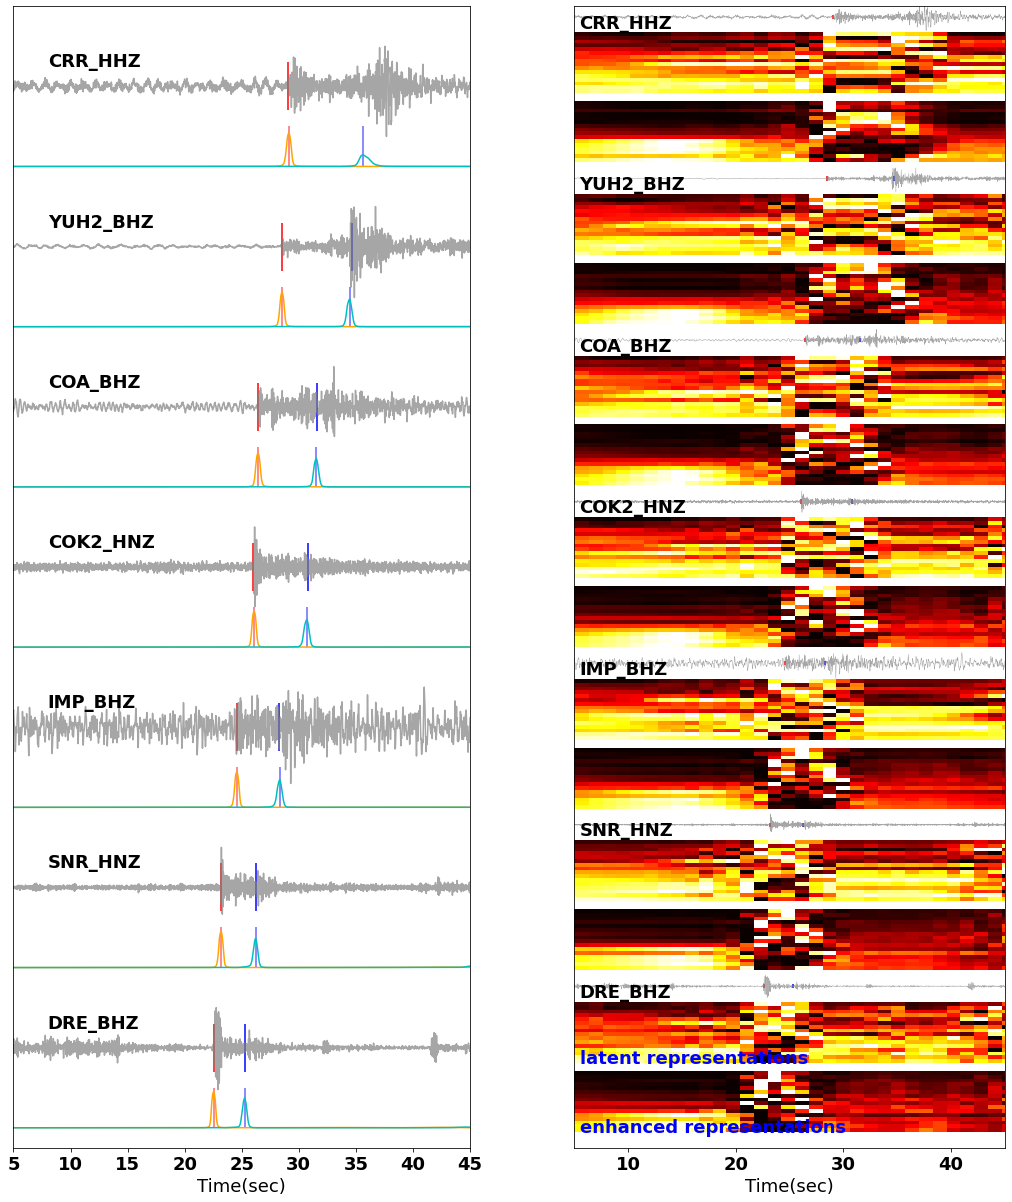

In [ ]:
# Visualize
## Feature Maps

idx=2

input_validset = Data_Path+'training_data/validation.npy'                  
gnn_weight_path = '/content/EdgePhase/models/Edgephase_step=52121.ckpt'

test = np.load(input_validset)
params_test = {'file_name': Data_Path+'training_data',  
                     'dim': 6000,
                     'batch_size': 1,
                     'shuffle': False,  
                     'norm_mode': 'std',
                     'augmentation': False}         

test_generator = DataGeneratorMulti(list_IDs=test,**params_test) 

eqt_model = sbm.EQTransformer.from_pretrained("original")
gnn_model = Graphmodel(eqt_model)
# CPU
state = torch.load(gnn_weight_path, map_location=torch.device('cpu'))['state_dict']
# GPU
# state = torch.load(gnn_weight_path)['state_dict']
gnn_model.load_state_dict( state_dict = state)
gnn_model.eval()



X = test_generator.testitem(idx)
wave=X[0].detach().numpy()

sta_name = X[4]
y_label = X[1].detach().numpy()
index=np.argsort(y_label,axis=0)
print('stations:',len(sta_name))
order = index[:,0]
for pivot,temp in enumerate(order):
    if y_label[temp,0]!=0:
        break
choice=range(pivot,len(order)-6,3)
select_list = order[choice]
select_list = select_list[:]
y_size=3*(len(select_list))


fig=plt.figure(figsize=(18,y_size))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

x_seq = np.arange(0,60,0.01)

scale =15
scale2 = 4
    
y_pre = torch.sigmoid(gnn_model.forward(X)).detach().numpy()
feature1, feature2 = gnn_model.out_feature_map(X)
feature1 = feature1.detach().numpy()
feature2 = feature2.detach().numpy()

for h,sta in enumerate(select_list):
    P_seq, S_seq = y_pre[sta,0], y_pre[sta,1]
    p=_detect_peaks(P_seq, mph=0.39, mpd=1)
    s=_detect_peaks(S_seq, mph=0.28, mpd=1)
    # plot waveforms
    ax1.plot(x_seq,wave[sta,2,:]/wave[sta,2,:].max()+scale*h,'gray',alpha=0.7,linewidth=0.5)
    ax0.plot(x_seq,wave[sta,2,:]/wave[sta,2,:].max()+scale2*h,'gray',alpha=0.7)

    p_label = y_label[sta,0]
    s_label = y_label[sta,1]
    p_label=p_label[p_label>0]
    s_label=s_label[s_label>0]

    # plot picks
    ax0.plot(x_seq,P_seq+scale2*h-2,'orange')
    ax0.vlines(p_label,scale2*h-0.6,scale2*h+0.6,'r')
    ax0.vlines(p/100.0,scale2*h-2,scale2*h-1,'r',alpha=0.6)
    ax0.plot(x_seq,S_seq+scale2*h-2,'c')
    ax0.vlines(s_label,scale2*h-0.6,scale2*h+0.6,'b')
    ax0.vlines(s/100.0,scale2*h-2,scale2*h-1,'b',alpha=0.6)
    ax0.text(8, scale2*h+0.5,sta_name[sta]+'Z')

    ax1.vlines(p_label,scale*h-0.2,scale*h+0.2,'r')
    
    ax1.vlines(s_label,scale*h-0.2,scale*h+0.2,'b')
    ax1.text(5.5, scale*h-1,sta_name[sta]+'Z')
    if h == 0:
      ax1.text(5.5, scale*h-scale/2+0.4,'latent representations',color='b')
      ax1.text(5.5, scale*h-scale+1.5,'enhanced representations ',color='b')

    f1 = feature1[sta].T-np.min(feature1[sta],axis=1)
    f1 = f1/np.max(f1,axis=0)

    f1 = f1[:,np.argsort(np.mean(f1,axis=0))]
    # plot feature maps
    ax1.imshow(f1[:,:].T, extent=(0, 60, scale*h-scale/2+0.4, scale*h-1.5),
    interpolation='nearest', cmap='hot')     

    f2 = feature2[sta].T-np.min(feature2[sta],axis=1)
    f2 = f2/np.max(f2,axis=0)
    f2 = f2[:,np.argsort(np.mean(f2,axis=0))]

    # plot feature maps
    ax1.imshow(f2[:,:].T, extent=(0, 60, scale*h-scale+1.5, scale*h-scale/2-0.4),
    interpolation='nearest', cmap='hot')

ax1.set_yticks([])
ax1.set_xlim([5,45])
ax1.set_ylim([-scale,scale*h+1])
ax1.set_xlabel('Time(sec)')

ax0.set_yticks([])
ax0.set_xlim([5,45])
ax0.set_ylim([-scale2+1.5,scale2*h+2])

ax0.set_xlabel('Time(sec)')


## Application of EdgePhase

### Run EdgePhase

In [ ]:
output_name ='./Result'
gnn_weight_path = '/content/EdgePhase/models/Edgephase_step=52121.ckpt'
      
df=pd.read_csv('/content/EdgePhase/Example/station.csv')
edge_index= torch.load('/content/EdgePhase/Example/edge_index.pt')

# load model
sig = nn.Sigmoid()
eqt_model = sbm.EQTransformer.from_pretrained("original")
eqt_model.eval()
gnn_model = Graphmodel(eqt_model)
# CPU
state = torch.load(gnn_weight_path, map_location=torch.device('cpu'))['state_dict']
# GPU
# state = torch.load(gnn_weight_path)['state_dict']

gnn_model.load_state_dict( state_dict = state)
gnn_model.eval()

# date_folder =  [str(i) for i in range(20201116,20201131)]


def _trim_nan(x):
        """
        Removes all starting and trailing nan values from a 1D array and returns the new array and the number of NaNs
        removed per side.
        """
        mask_forward = np.cumprod(np.isnan(x)).astype(
            bool
        )  # cumprod will be one until the first non-Nan value
        x = x[~mask_forward]
        mask_backward = np.cumprod(np.isnan(x)[::-1])[::-1].astype(
            bool
        )  # Double reverse for a backwards cumprod
        x = x[~mask_backward]

        return x, np.sum(mask_forward.astype(int)), np.sum(mask_backward.astype(int))

directory = os.path.join(output_name)
if not os.path.exists(directory):
    os.makedirs(directory)

bg_st=obspy.core.Stream()
print('reading waveforms')
for net,sta in tqdm(zip(df['network'],df['station'])): 
    bg_st += obspy.read(os.path.join(Data_Path,'continous_data',net+'_'+sta+'.mseed'))

split_points=list(range(3,len(bg_st),3))
preds = []
starts = []
in_samples = 6000
overlap = 1800
steps = in_samples - overlap
trace_stats=[]
for ii in list(range(0,len(bg_st),3)):
    tr = bg_st[ii]
    trace_stats.append(tr.stats)

print('predicting')

for index, windowed_st in enumerate(tqdm(bg_st.slide(window_length=60.0, step=steps/100.0,include_partial_windows=False))): 
    s = index*steps#windowed_st[0].stats.starttime
    if len(windowed_st)!=len(bg_st):
        print('skip')
        preds.append(np.zeros((len(df),2,6000)))
        starts.append(s)
        continue
    start_trim = min([tr.stats.starttime for tr in windowed_st])
    end_trim = max([tr.stats.endtime for tr in windowed_st])
    windowed_st.trim(start_trim, max(start_trim+60, end_trim) , pad=True, fill_value=0)
    temp=np.array(windowed_st)[:,:6000]
    temp = np.split(temp,split_points)
    temp = np.array(temp,dtype=float)
    temp = temp - np.mean(temp,axis=-1,keepdims=True)
    std_data = np.std(temp,axis=-1,keepdims=True)
    std_data[std_data == 0] = 1
    temp = temp/std_data
    temp = torch.tensor(temp, dtype=torch.float)
    res=torch.sigmoid(gnn_model.forward((temp,None,edge_index)))
    preds.append(res.detach().numpy())
    starts.append(s)

del bg_st
gc.collect()

prediction_sample_factor=1
# Maximum number of predictions covering a point
coverage = int(
    np.ceil(in_samples / (in_samples - overlap) + 1)
)
print('coverage',coverage)
pred_length = int(
    np.ceil(
        (np.max(starts)+in_samples) * prediction_sample_factor
    )
)
pred_merge = (
    np.zeros_like(
        preds[0], shape=( preds[0].shape[0],preds[0].shape[1], pred_length, coverage)
    )
    * np.nan
)

for i, (pred, start) in enumerate(zip(preds, starts)):
                pred_start = int(start * prediction_sample_factor)
                pred_merge[
                    :,:, pred_start : pred_start + pred.shape[2], i % coverage
                ] = pred
print('pred_merge',pred_merge.shape)

del preds
gc.collect()

# del pred_merge

label_name=["GNN_P","GNN_S"]
pred_rate =100
print('writing to mseed')

for k in range(len(df['station'])):
    # print(k,trace_stats[k].network+'_'+trace_stats[k].station)
    output = obspy.Stream()
    pred = np.nanmean(pred_merge[k], axis=-1)
#     trace_stats = bg_st[k].stats
    for i in range(2):

        trimmed_pred, f, _ = _trim_nan(pred[i])
        trimmed_start = trace_stats[k].starttime + f / pred_rate

        output.append(
            obspy.Trace(
                trimmed_pred,
                {
                    "starttime": trimmed_start,
                    "sampling_rate": pred_rate,
                    "network": trace_stats[k].network,
                    "station": trace_stats[k].station,
                    "location": trace_stats[k].location,
                    "channel": label_name[i],
                },
            )
        )
    output.write(os.path.join(directory, trace_stats[k].network+'_'+trace_stats[k].station+'.mseed'), format='MSEED')
    del output
    gc.collect()
del pred_merge
gc.collect()


loss weight [0.5, 0.5]
reading waveforms


72it [01:07,  1.06it/s]


predicting


85it [02:50,  2.01s/it]


coverage 3
pred_merge (72, 2, 358800, 3)
writing to mseed


0

### Pick Phases

In [ ]:
base_folder='Result2'
df=pd.read_csv('/content/EdgePhase/Example/station.csv')

for net, sta in zip(df['network'],df['station']):
    print(net,sta)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder) 
    fileP=base_folder+'/'+net+'.'+sta+'.P.txt'
    fileS=base_folder+'/'+net+'.'+sta+'.S.txt'
    p_picks=[]
    s_picks=[]
    
    starttime = obspy.core.UTCDateTime('2020-10-31', iso8601=True)  
    # print(starttime)
    st = obspy.read(output_name+'/'+net+'_'+sta+'.mseed')
    add_on = st[0].stats.starttime-starttime
    # print(st[0].stats.starttime,add_on)
    P_seq, S_seq = np.array(st[0]), np.array(st[1])
    p=_detect_peaks(P_seq, mph=0.12, mpd=1)
    s=_detect_peaks(S_seq, mph=0.15, mpd=1)

    for i in p:      
        p_picks.append([i/100.0+add_on,P_seq[i],0])
    for i in s:
        s_picks.append([i/100.0+add_on,S_seq[i],0])

    np.savetxt(fileP,np.array(p_picks))
    np.savetxt(fileS,np.array(s_picks))


KO EDC
KO EZN
KO GEDZ
KO GELI
KO KRBG
KO MRMT
KO TVSB
KO GAZK
KO YAYO
KO APMY
KO FETY
KO BASM
KO CESE
KO DATC
KO DIDI
KO ENZZ
KO FOCM
KO GMLD
KO GOMA
KO KHL
KO KRBN
KO KUSD
KO YKAV
KO GORD
KO NAZL
KO SOMA
KO SUSR
KO CANM
KO CAME
HL PTL
HL SAP3
HL LIA
HL ZKR
HL VLY
HL THERA
HL DION
HL ARG
HL KARP
HL EAG2
HL NPS
HL SMTH
HL APE
HL PRK
HL SKY
HL KSL
HL KYMI
HL MHLO
HL ATH
HC STIA
HC PFKS
HI NAX1
HI SIT2
HI KSS1
HI SKY1
HI KRL1
HI SFL1
HI MYT1
HI ATH5
HI RDI1
HI LMN1
HT CMBO
HT THAS
HT ALN
HT CHOS
HT AOS2
HA STFN
HA SNT5
HA VILL
HA ATHU
HA KARY
HA MDRA
HA MRTH


([], <a list of 0 Text major ticklabel objects>)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


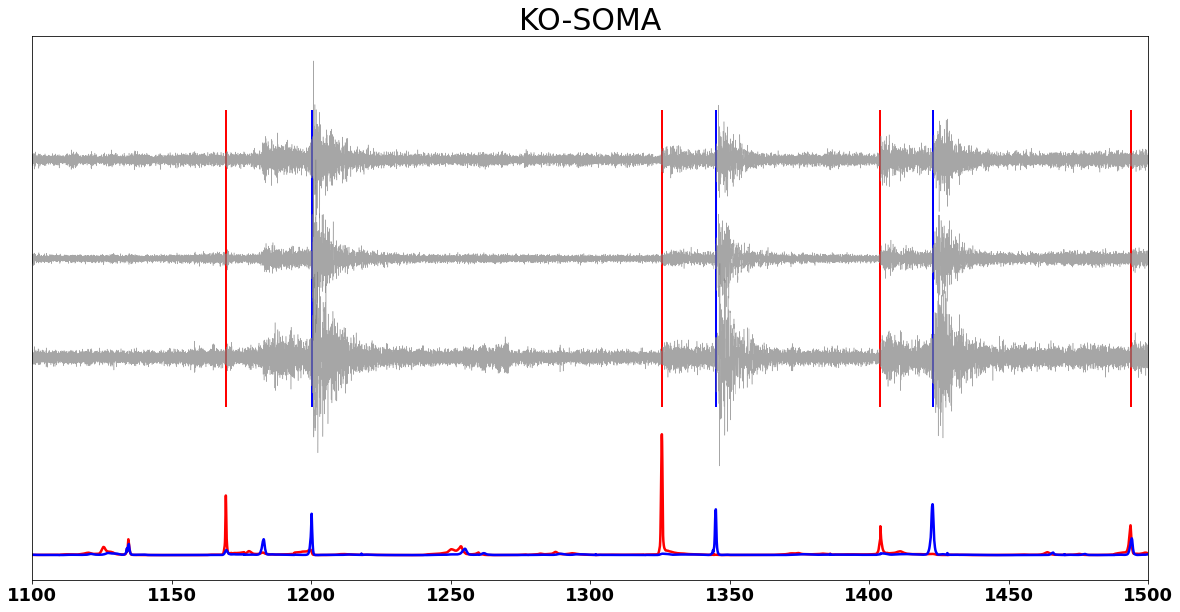

In [ ]:
# visualize continous waveforms
net = 'KO'
station = 'SOMA'

waveform_file = Data_Path+'/continous_data/'+net+'_'+station+'.mseed'
prob_file = '/content/Result/'+net+'_'+station+'.mseed'
phaseP_file = '/content/Result2/'+net+'.'+station+'.P.txt'
phaseS_file = '/content/Result2/'+net+'.'+station+'.S.txt'

wave = obspy.read(waveform_file)
prob = obspy.read(prob_file)
P = np.loadtxt(phaseP_file)
S = np.loadtxt(phaseS_file)
P_phases=P[:,0]-9*3600
S_phases=S[:,0]-9*3600

x_seq = np.arange(0, wave[0].meta.npts/100, 0.01)
x_prob = np.arange(0, prob[0].meta.npts/100, 0.01)

wave = np.array(wave)
prob = np.array(prob)

fig=plt.figure(figsize=(20,10))
plt.plot(x_seq,wave[0,:]/wave[0,:].max()-1,'gray',alpha=0.7,linewidth=0.5)
plt.plot(x_seq,wave[1,:]/wave[1,:].max(),'gray',alpha=0.7,linewidth=0.5)
plt.plot(x_seq,wave[2,:]/wave[2,:].max()+1,'gray',alpha=0.7,linewidth=0.5)
plt.vlines(P_phases,-1.5,1.5,'r',linewidth=2)
plt.vlines(S_phases,-1.5,1.5,'b',linewidth=2)
plt.plot(x_prob,prob[0]*2-3,'red',linewidth=2.5)
plt.plot(x_prob,prob[1]*2-3,'blue',linewidth=2.5)
plt.title(net+'-'+station,fontsize=30)
plt.xlim([1100,1500])
plt.yticks([])

## Rapid Earthquake Association and Location (REAL)
[github repo](https://github.com/Dal-mzhang/REAL)

In [ ]:
! git clone https://github.com/Dal-mzhang/REAL

Cloning into 'REAL'...
remote: Enumerating objects: 820, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 820 (delta 36), reused 24 (delta 24), pack-reused 766
Receiving objects: 100% (820/820), 13.52 MiB | 13.47 MiB/s, done.
Resolving deltas: 100% (428/428), done.


In [ ]:
% cd /content/REAL/src/REAL/
!make
% cd /content

/content/REAL/src/REAL
gcc-10 -Os -fopenmp -W     -c -o REAL.o REAL.c
make: gcc-10: Command not found
<builtin>: recipe for target 'REAL.o' failed
make: *** [REAL.o] Error 127
/content


In [ ]:
D = "2020/10/30"
R = "0.55/30/0.03/5/5/360/180/37.9175/26.7901";
V = "6.2/3.3";
G = "4/30/0.01/2";
dir = "../phase_30day_sel/$year$mon$day";
station = "/content/EdgePhase/Example/EqLocation/REAL/station.dat";
ttime = "/content/EdgePhase/Example/EqLocation/REAL/ttdb_small.txt";
!system("REAL")# -D$D -R$R -G$G -S$S -V$V $station $dir $ttime");


/bin/bash: -c: line 0: syntax error near unexpected token `"REAL"'
/bin/bash: -c: line 0: `system("REAL")# -D2020/10/30 -R0.55/30/0.03/5/5/360/180/37.9175/26.7901 -G4/30/0.01/2 -S[[3.25966600e+04 3.72332036e-01 0.00000000e+00]'


In [ ]:
!REAL

/bin/bash: REAL: command not found
